In [1]:
pip install sklearn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# importing layers from keras
from keras.layers import Dense, InputLayer, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential
#for instantiating the model and loading the weights and biases
from keras.applications.resnet_v2 import ResNet152V2
# importing adam optimizer from tensorflow keras optimizer module 
from tensorflow.keras.optimizers import Adam
# defining model checkpointing
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# importing ImageDataGererator for loading images
from keras.preprocessing.image import ImageDataGenerator

# train_test_split to create training and validation set
from sklearn.model_selection import train_test_split
# accuracy_score to calculate the accuracy of predictions
from sklearn.metrics import accuracy_score

# ignore warning
import warnings
warnings.filterwarnings("ignore")

2022-01-19 07:33:46.361297: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


### Loading the dataset

In [3]:
data = pd.read_csv('datasets/sceneclassificationdataset/train.csv', dtype=str)

In [4]:
data['label'].value_counts()

3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: label, dtype: int64

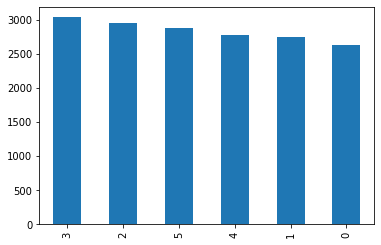

In [5]:
data['label'].value_counts().plot(kind='bar');

In [ ]:
# data between classes is well distributed

### Creating Training and Validation set

In [6]:
# create random number generator
seed = 42

In [7]:
# creating a training and validation set
train_data, validation_data = train_test_split(data,test_size=0.3, random_state=seed)

In [8]:
# shape of training and validation set
train_data.shape, validation_data.shape

((11923, 2), (5111, 2))

### Image Aumentation

In [9]:
# Augmentation
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8],  # brightness
                                   rescale=1./255, # normalize data
                                   shear_range=0.2) 

test_datagen = ImageDataGenerator(rescale=1./255)

### Loading the data

In [10]:
# Training Set Directory
path = 'datasets/sceneclassificationdataset/train/'

In [11]:
# load train data
train=train_datagen.flow_from_dataframe(dataframe = train_data,           # Training Dataframe
                                      directory=path,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_name",               # Input Column
                                      
                                      y_col="label",                    # Target Column
                                      color_mode="rgb",                 # Image Format
                                      target_size=(224,224))            # Image Size

Found 11923 validated image filenames belonging to 6 classes.


In [12]:
# load validation data
valid = test_datagen.flow_from_dataframe(dataframe = validation_data,    # Validation Dataframe
                                    directory=path,                 # Validation set Directory
                                    batch_size=20,                  # Size of Batch
                                    class_mode="categorical",       # Type of Labels
                                    x_col="image_name",             # Input Column
                                    color_mode="rgb",               # Image Format
                                    y_col="label",                  # Target Column
                                    target_size=(224,224))          # Image Size
                                    

Found 5111 validated image filenames belonging to 6 classes.


### Load weights from pretrained model

In [13]:
# use garbage collector to prevent memory error
import gc
gc.collect()

3295

In [14]:
# load weights and model structure from ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

2022-01-19 07:34:02.021226: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-01-19 07:34:02.096144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-19 07:34:02.096209: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 07:34:02.102183: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-19 07:34:02.102266: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-01-19 07:34:02.105011: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcufft.so.1

In [62]:
# show models structure
# base_model.summary()

In [15]:
# Freezing all layers other than last 15 Layers
for layer in base_model.layers[:-15]:       
    layer.trainable = False

In [16]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(units=6, activation='softmax')(x)
model = Model(base_model.input, output)
# model.summary()

In [20]:
# compile the model
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

### Training the Model

In [21]:
# defining the path to save the model
path = 'best_model_resnet_7.hdf5'

# defining model checkpointing
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')

# defining model early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', verbose = 1, min_delta=0.0001, patience=6, mode='max')

# reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5,  verbose = 1)

# defining callback list
callback_list = [checkpoint, early_stopping, reduce_lr]

In [22]:
# training the model for 50 epochs
model_history = model.fit(train, epochs=50, validation_data=valid, callbacks=callback_list)

2022-01-19 07:34:26.985729: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 07:34:27.005828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/50


2022-01-19 07:35:08.086351: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-01-19 07:35:08.741030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-01-19 07:35:09.476791: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-19 07:35:10.082050: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


597/597 [==============================] - 231s 314ms/step - loss: 0.1854 - accuracy: 0.9431 - val_loss: 0.3089 - val_accuracy: 0.9249

Epoch 00001: val_accuracy improved from -inf to 0.92487, saving model to best_model_resnet_7.hdf5
Epoch 2/50
597/597 [==============================] - 177s 296ms/step - loss: 0.1899 - accuracy: 0.9424 - val_loss: 0.3184 - val_accuracy: 0.9300

Epoch 00002: val_accuracy improved from 0.92487 to 0.92996, saving model to best_model_resnet_7.hdf5
Epoch 3/50
597/597 [==============================] - 178s 299ms/step - loss: 0.2006 - accuracy: 0.9416 - val_loss: 0.2886 - val_accuracy: 0.9290

Epoch 00003: val_accuracy did not improve from 0.92996
Epoch 4/50
597/597 [==============================] - 178s 298ms/step - loss: 0.1570 - accuracy: 0.9501 - val_loss: 0.3526 - val_accuracy: 0.9323

Epoch 00004: val_accuracy improved from 0.92996 to 0.93230, saving model to best_model_resnet_7.hdf5
Epoch 5/50
597/597 [==============================] - 177s 297ms/ste

### Evaluating model performance

In [23]:
model.load_weights('best_model_resnet_7.hdf5')

In [24]:
# accuracy on training set
score, acc = model.evaluate(train)
print('Test score:', score)
print('Test accuracy:', acc)

597/597 [==============================] - 152s 255ms/step - loss: 0.0998 - accuracy: 0.9668
Test score: 0.09976115822792053
Test accuracy: 0.9667868614196777


In [25]:
# accuracy on validation set
score, acc = model.evaluate(valid)
print('Test score:', score)
print('Test accuracy:', acc)

256/256 [==============================] - 24s 93ms/step - loss: 0.3526 - accuracy: 0.9323
Test score: 0.3525985777378082
Test accuracy: 0.9323028922080994


### Evaluating model performance on test data

In [28]:
# load test data
test_data = pd.read_csv('datasets/sceneclassificationdataset/test_Dg8GF4p.csv')

In [29]:
import cv2

In [30]:
# empty list to store the images
X_test = []
# iterating over each image
for img_name in test_data.image_name:
    # loading the image using its name
    img = Image.open('datasets/sceneclassificationdataset/train/' + img_name)
    # reshape image to (224,224)
    img = img.resize((224,224))
    a = np.asarray(img)   
    # change images with 2 channels to 3
    if a.shape != (224,224, 3):
        a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB)
    # saving each image in the list
    X_test.append(a)


In [31]:
# converting the list of images into array
X_test=np.array(X_test)

In [32]:
# normalize X_test
X_test = X_test /255

In [33]:
# predict classes for test data
predict = np.argmax(model.predict(X_test), axis=-1)

In [34]:
# add column label with predictions
test_data['label'] = predict

In [36]:
# save results to csv
test_data.to_csv('resnet_7.csv', index=False)